In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from windrose import WindroseAxes
import matplotlib.cm as cm
from windrose import plot_windrose
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
working_dir = os.getcwd()
data_dir = working_dir + '/Data/'

In [3]:
traindata = pd.read_csv(data_dir + 'TrainData.csv')
forecast_input = pd.read_csv(data_dir + "WeatherForecastInput.csv")
solution = pd.read_csv(data_dir + "Solution.csv")

forecast_input = forecast_input.drop(['U100', 'V100', 'WS100'], axis=1)

traindata = traindata.drop(['U100', 'V100', 'WS100'], axis=1)
traindata

,TIMESTAMP,POWER,U10,V10,WS10
0,20120101 1:00,0.273678,0.534894,-3.660243,3.699120
1,20120101 2:00,0.086796,0.330813,-2.676430,2.696797
2,20120101 3:00,0.006811,-0.065839,-2.029072,2.030140
3,20120101 4:00,0.018646,-0.419549,-1.799090,1.847362
4,20120101 5:00,0.034812,-0.754224,-1.661526,1.824698
...,...,...,...,...,...
16075,20131031 20:00,0.101254,-1.459917,-1.778960,2.301316
16076,20131031 21:00,0.105047,-1.293326,-2.350447,2.682777
16077,20131031 22:00,0.145079,-0.308284,-2.441885,2.461269
16078,20131031 23:00,0.180933,1.148765,-2.789011,3.016330


In [4]:
def wind_uv_to_dir(U,V):
    """
    Calculates the wind direction from the u and v component of wind.
    Takes into account the wind direction coordinates is different than the 
    trig unit circle coordinate. If the wind directin is 360 then returns zero
    (by %360)
    Inputs:
      U = west/east direction (wind from the west is positive, from the east is negative)
      V = south/noth direction (wind from the south is positive, from the north is negative)
    """
    WDIR= (270-np.rad2deg(np.arctan2(V,U)))%360
    return WDIR

In [5]:
U = traindata.filter(['U10']).values
V = traindata.filter(['V10']).values
wd = wind_uv_to_dir(U,V)
traindata["WD10"] = wd

wds = wind_uv_to_dir(forecast_input.filter(['U10']).values,forecast_input.filter(['V10']).values)
forecast_input["WD10"] = wds
forecast_input = forecast_input.filter(['WS10',"WD10"])
wd

array([[351.68586477],
       [352.95384269],
       [  1.85846441],
       ...,
       [  7.1954325 ],
       [337.613739  ],
       [305.81562933]])

In [6]:
X = traindata[['WS10', 'WD10']]
y = traindata['POWER']

In [7]:
regr = linear_model.LinearRegression()
regr.fit(X, y)

LinearRegression()

In [8]:
prediction = regr.predict(forecast_input)
prediction

array([ 0.35278186,  0.35906159,  0.3604764 ,  0.35531714,  0.36930461,
        0.37220174,  0.33568925,  0.22648548,  0.15838947,  0.03636161,
        0.00159319,  0.05069885,  0.07137814,  0.03547601, -0.0249989 ,
        0.04854513,  0.07236372,  0.09573544,  0.06736497, -0.02013567,
        0.01023778,  0.09085697,  0.12823159,  0.19366751,  0.42378969,
        0.4745107 ,  0.54175753,  0.61622029,  0.64523985,  0.60018125,
        0.53975664,  0.51458964,  0.51892841,  0.46821921,  0.41750394,
        0.33699424,  0.47226263,  0.57269761,  0.32638712,  0.37627475,
        0.48332154,  0.53751091,  0.47709282,  0.40148883,  0.4443809 ,
        0.5238346 ,  0.51585496,  0.50552962,  0.44861834,  0.45764789,
        0.59152863,  0.62441504,  0.60312219,  0.60201884,  0.59913388,
        0.59508835,  0.53084583,  0.46141661,  0.39646393,  0.5407979 ,
        0.55645199,  0.59600512,  0.65008363,  0.68915196,  0.71537294,
        0.73664461,  0.75200209,  0.77082587,  0.80620328,  0.87

In [9]:
mse = mean_squared_error(solution['POWER'],prediction)
rmse = np.sqrt(mse)
rmse

0.2149417156390323

In [10]:
print("Training set score svr: {:.2f}".format(regr.score(X, y)))
print("Prediction set score svr: {:.2f}".format(regr.score(forecast_input, solution.filter(['POWER'], axis=1))))

Training set score svr: 0.53
Prediction set score svr: 0.46


In [11]:
solution = pd.read_csv(data_dir + "Solution.csv")
solved = solution.drop(['POWER'], axis=1)
solved["FORECAST"] = prediction
solved.to_csv(data_dir+"ForecastTemplate2.csv")

In [13]:
traindata2 = pd.read_csv(data_dir + 'TrainData.csv')
forecast_input2 = pd.read_csv(data_dir + "WeatherForecastInput.csv").filter(['WS10'])

traindata2 = traindata2.drop(['U100', 'V100', 'WS100'], axis=1)

X2 = traindata2.filter(['WS10']).values
y2 = traindata2.filter(['POWER']).values

regr2 = linear_model.LinearRegression()
regr2.fit(X2, y2)                

prediction2 = regr2.predict(forecast_input2)

Text(0.5, 1.0, 'Multi Linear Regression')

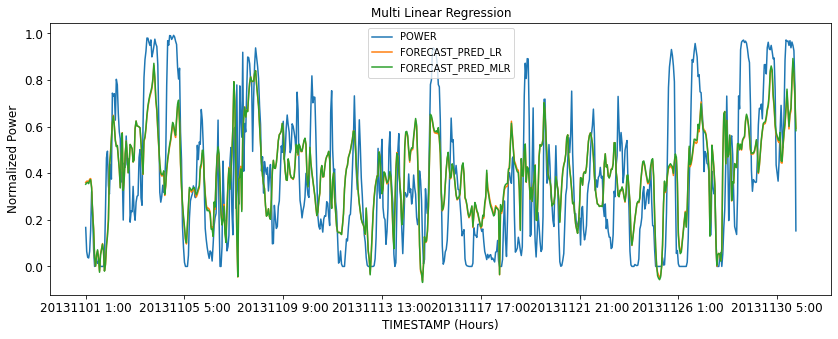

In [14]:
solution = solution.set_index('TIMESTAMP')
solvedPlot = solution
solvedPlot["FORECAST_PRED_LR"] = prediction2
solvedPlot["FORECAST_PRED_MLR"] = prediction
ax1=solvedPlot.plot(figsize=(14,5), fontsize =12)
ax1.set_xlabel("TIMESTAMP (Hours)",fontdict={'fontsize':12})
ax1.set_ylabel("Normalized Power",fontdict={'fontsize':12})
ax1.set_title("Multi Linear Regression",fontdict={'fontsize':12})

[Text(0.0, 0, 'East'),
 Text(0.7853981633974483, 0, 'North-East'),
 Text(1.5707963267948966, 0, 'North'),
 Text(2.356194490192345, 0, 'North-West'),
 Text(3.141592653589793, 0, 'West'),
 Text(3.9269908169872414, 0, 'South-West'),
 Text(4.71238898038469, 0, 'South'),
 Text(5.497787143782138, 0, 'South-East')]

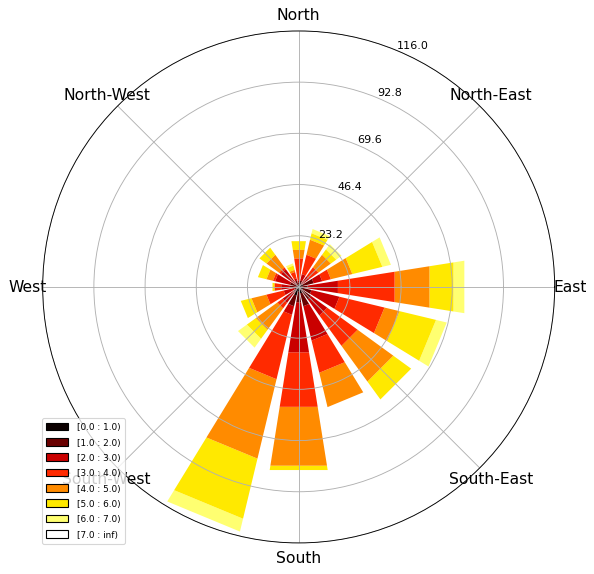

In [15]:
forecast_input = forecast_input.rename(columns={"WS10": "speed", "WD10": "direction"})
ax =plot_windrose(forecast_input, kind='bar', bins=np.arange(0.01,8,1), cmap=cm.hot, lw=3)
ax.set_xticklabels(["East", "North-East", "North", "North-West", "West", "South-West", "South", "South-East"], fontsize=14)